### **Understanding the problem** ###


#### Target Output: `sii`

The `sii` column represents the Severity Impairment Index (SII), which is used to classify the severity of problematic internet use. It follows a scale defined as:

- **0**: None
- **1**: Mild
- **2**: Moderate
- **3**: Severe

Target `sii` is derived from the field `PCIAT-PCIAT_Total`.

#### Data Inputs:

- Internet usage behavior data
    - `Train.csv` (2736 ids has value in `sii`)
- Accelerometer time series data for single `id`, to be used as training data
    - `id.parquet` (available for  996 `id` in total)
    
Number of `id`(s) have both `sii` value and `id.parquet` file: 996

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
import seaborn as sns

### Data ingestion ###

In [18]:
# Load csv files into csv_file, within csv_file, each csv file is created as a df using the name of csv file.
csv_file = {}

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.csv'):
            key = filename.split('.')[0]
            csv_file[key] = pd.read_csv(os.path.join(dirname, filename))
            globals()[key] = csv_file[key] 

In [5]:
# Load ids contained in parquet files name into list_id 
list_id = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.parquet'):
            string = os.path.join(dirname, filename)
            id = string.split('/')[-2].split('=')[-1]
            list_id.append(id)
# count number of ids contained in parquet files name            
num_id = len(set(list_id))
print(num_id)

# load first paquet file 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.parquet'):
            parquet_file1 = pd.read_parquet(os.path.join(dirname, filename))
            break
parquet_file1.shape

996


(342324, 13)

In [19]:
# Check train csv file
X_train = train
train.head()
#train[train['id'] == '5f099188']

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **Missing value in column `sii`** ###

In [7]:
X_train.shape

(3960, 82)

In [20]:
X_train = train[train['sii'].notna()] # select rows where column sii is not null in train
id_sii_not_null = train[train['sii'].notna()]['id'].tolist() # get list of ids having non-null sii value.
print("Number of ids that has not null sii in train dataset: ", len(set(id_sii_not_null)))

Number of ids that has not null sii in train dataset:  2736


### **EDA** ###

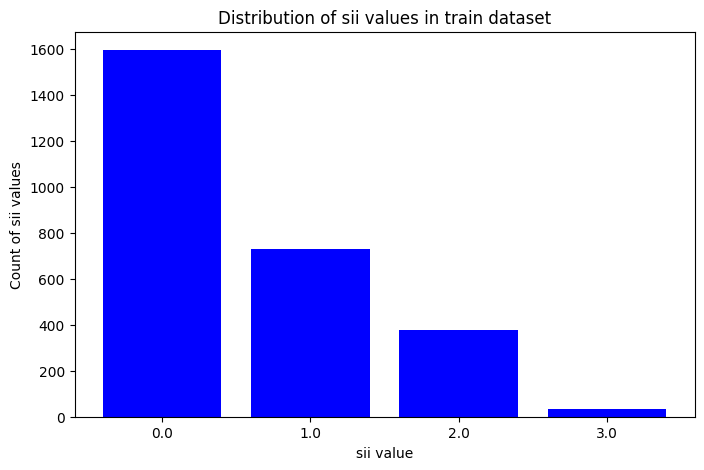

In [21]:
# count number of ids per sii value
sii_counts = X_train['sii'].value_counts()
# plot distritbuion of sii values
plt.figure(figsize = (8,5))
plt.bar(sii_counts.index, sii_counts.values, color = 'blue')
plt.xticks(ticks = sii_counts.index, labels = sii_counts.index)
plt.ylabel("Count of sii values")
plt.xlabel("sii value")
plt.title("Distribution of sii values in train dataset")
plt.show()

In [22]:
# get min and max PCIAT-PCIAT-Total score of sii values
result = X_train.groupby('sii')['PCIAT-PCIAT_Total'].agg([min, max]).reset_index()
result['count'] = sii_counts.values
result['count %'] = np.round(sii_counts.values / 2736,2)
result

/tmp/ipykernel_30/4217922965.py:2: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  result = X_train.groupby('sii')['PCIAT-PCIAT_Total'].agg([min, max]).reset_index()
/tmp/ipykernel_30/4217922965.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  result = X_train.groupby('sii')['PCIAT-PCIAT_Total'].agg([min, max]).reset_index()


,sii,min,max,count,count %
0,0.0,0.0,30.0,1594,0.58
1,1.0,31.0,49.0,730,0.27
2,2.0,50.0,79.0,378,0.14
3,3.0,80.0,93.0,34,0.01


### **Feature selection** ###

We know `PCIAT-PCIAT_Total` is a function of `PCIAT-PCIAT_XX`(s), which therefore can be dropped from the features.

In [23]:
# Drop "PCIAT-PCIAT_XX" columns and only keep the "PCIAT-PCIAT_Total" column
PCIAT_cols = [col for col in X_train.columns if col.startswith('PCIAT-PCIAT') and col != 'PCIAT-PCIAT_Total']
X_train = X_train.drop(columns = PCIAT_cols)
X_train.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,NaN,NaN,Fall,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,Fall,2.340,Fall,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,Summer,2.170,Fall,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,Winter,2.451,Summer,44.0,Summer,31.0,45.0,Winter,0.0,1.0
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,...,Spring,4.110,Summer,34.0,Summer,40.0,56.0,Spring,0.0,1.0


In [25]:
# Check missing values
missing_values = X_train.isnull().sum()
missing_percent= round(X_train.isnull().mean() *100,1)
missing_percent_df = pd.DataFrame(
    {'feature': missing_percent.index,
     'missing_percent': missing_percent.values})
missing_percent_df = missing_percent_df.sort_values(by = 'missing_percent', ascending = True)

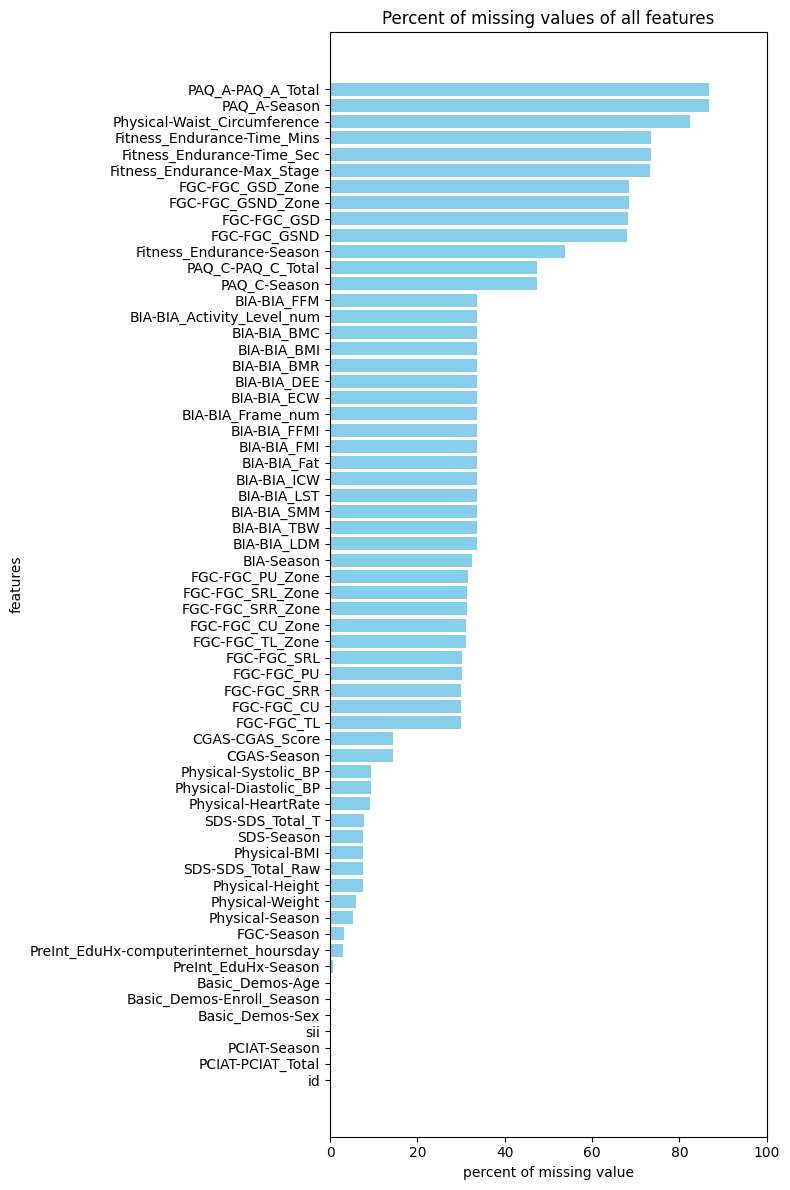

In [15]:
# Plot bar chart of missing values by features
plt.figure(figsize = (8,12)) # set figure size
plt.barh(missing_percent_df['feature'], missing_percent_df['missing_percent'],color = 'skyblue') # plot vertical bar chart
plt.xlabel("percent of missing value")
plt.ylabel("features")
plt.title("Percent of missing values of all features")
plt.xlim(0,100)
plt.tight_layout()
plt.show()

In [26]:
## setting missing value percent threshold  = 30%, drop features have >=30% missing values
missing_percent_df = missing_percent_df[missing_percent_df['missing_percent']>=30].sort_values(by='missing_percent',ascending = False).reset_index(drop = True)
missingvalue_cols = missing_percent_df['feature'].tolist()
X_train = X_train.drop(columns = missingvalue_cols)

In [27]:
## check left features in X_train
X_train.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,FGC-FGC_CU,FGC-FGC_TL,PCIAT-Season,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,0.0,6.0,Fall,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,3.0,3.0,Fall,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,20.0,5.0,Fall,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,18.0,7.0,Summer,44.0,Summer,31.0,45.0,Winter,0.0,1.0
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,...,12.0,8.0,Summer,34.0,Summer,40.0,56.0,Spring,0.0,1.0


### **Create target value train set y_train** ###

In [28]:
# Create target train set y_train
y_train = X_train['sii'] # get Y_train 
y_train.head()

0    2.0
1    0.0
2    0.0
3    1.0
5    1.0
Name: sii, dtype: float64

### **Feature preprocessing** ###

In [29]:
# address missing values in X_train
for col in X_train:
    if X_train[col].dtype == 'object':
       X_train[col].fillna('missing', inplace = True)
    else:
       X_train[col].fillna(0,inplace = True)

/tmp/ipykernel_30/227117549.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna('missing', inplace = True)
/tmp/ipykernel_30/227117549.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [30]:
# Shuffle X_train, y_train
tf.random.set_seed(0)

X_train, y_train = shuffle(X_train, y_train, random_state = 42)

In [31]:
# Train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 1234)

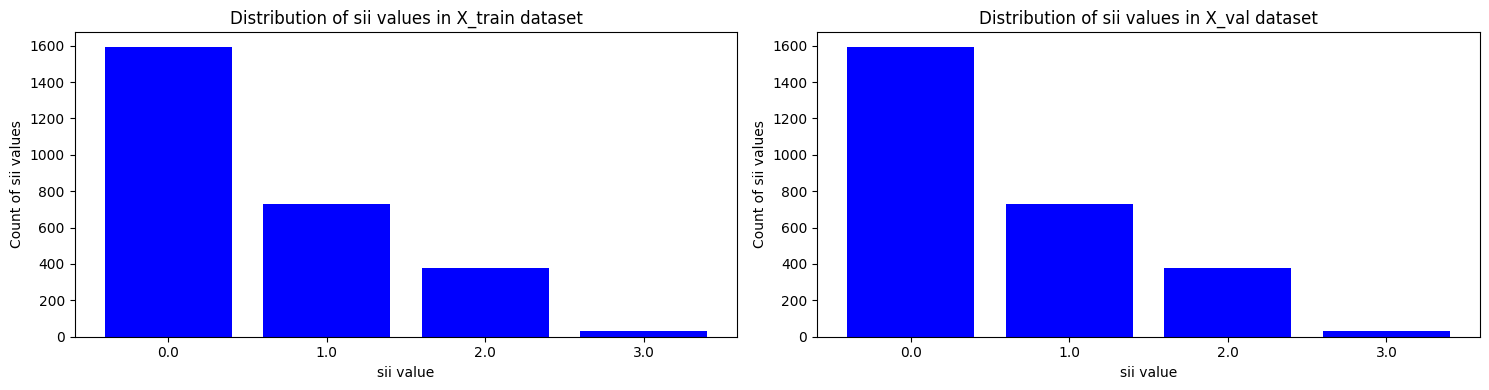

In [32]:
# count number of ids per sii value
train_dist = X_train['sii'].value_counts()
# plot distritbuion of sii values
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.bar(sii_counts.index, sii_counts.values, color = 'blue')
plt.xticks(ticks = sii_counts.index, labels = sii_counts.index)
plt.ylabel("Count of sii values")
plt.xlabel("sii value")
plt.title("Distribution of sii values in X_train dataset")

# count number of ids per sii value
val_dist = X_val['sii'].value_counts()
# plot distritbuion of sii values
plt.subplot(1,2,2)
plt.bar(sii_counts.index, sii_counts.values, color = 'blue')
plt.xticks(ticks = sii_counts.index, labels = sii_counts.index)
plt.ylabel("Count of sii values")
plt.xlabel("sii value")
plt.title("Distribution of sii values in X_val dataset")
plt.tight_layout()

plt.show()

In [33]:
# Features transformation - OneHotEncoder
encoder = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)
X_train_encoded = encoder.fit_transform (X_train)
X_train_enc = pd.DataFrame(X_train_encoded, columns = encoder.get_feature_names_out(X_train.columns.tolist()))
X_val_encoded = encoder.transform(X_val)
X_val_enc = pd.DataFrame(X_val_encoded, columns = encoder.get_feature_names_out(X_val.columns.tolist()))

In [34]:
# Label transformation
y_train_v = to_categorical(y_train, num_classes = 4)
y_val_v = to_categorical(y_val, num_classes = 4)

### **Baseline model - Neural Network Model** ###

In [74]:
tf.random.set_seed(1234)
np.random.seed(1234)

def build_model(X_train, y_train, X_val, y_val, learning_rate, num_features,num_epochs = 10, batch_size = 32):
    tf.keras.backend.clear_session()
     # Build a model using keras.Sequential. 
    model = tf.keras.Sequential()

# Add a hidden layer with 64 neurons and ReLU activation
    model.add(tf.keras.layers.Dense(
        units=64,                    # Number of neurons in the hidden layer
        activation='relu',          # ReLU activation for hidden layer
        input_shape=(X_train.shape[1],)  # Use number of features in X_train
    ))
  # Output layer with softmax activation
    model.add(tf.keras.layers.Dense(
        units=4,                    # Output layer with the number of classes
        activation='softmax',          # softmax activation
        kernel_regularizer=tf.keras.regularizers.l2(0.01)  # L2 regularization
    ))
  
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    # set schedule to adjust learning rate 
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
   lambda epoch: learning_rate * (0.1 ** (epoch // 10))
    )
    # Step 3: Train the Model
    history = model.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks = [lr_schedule]
    )
    return model

In [ ]:
X_train_enc.shape

In [ ]:
X_val_enc.shape

In [ ]:
y_train.shape

In [ ]:
y_val.shape

In [75]:
num_features = X_train_enc.shape[1]
model_tf = build_model(X_train = X_train_enc, y_train = y_train_v, X_val = X_val_enc, y_val  = y_val_v, num_features=num_features, num_epochs = 15, learning_rate=0.1)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 - 1s - 17ms/step - accuracy: 0.8319 - loss: 0.6695 - val_accuracy: 0.9915 - val_loss: 0.2868 - learning_rate: 0.1000
Epoch 2/15
60/60 - 0s - 5ms/step - accuracy: 0.9859 - loss: 0.2421 - val_accuracy: 0.9915 - val_loss: 0.1862 - learning_rate: 0.1000
Epoch 3/15
60/60 - 0s - 5ms/step - accuracy: 0.9859 - loss: 0.1820 - val_accuracy: 0.9915 - val_loss: 0.1576 - learning_rate: 0.1000
Epoch 4/15
60/60 - 0s - 5ms/step - accuracy: 0.9859 - loss: 0.1577 - val_accuracy: 0.9915 - val_loss: 0.1415 - learning_rate: 0.1000
Epoch 5/15
60/60 - 0s - 5ms/step - accuracy: 0.9859 - loss: 0.1424 - val_accuracy: 0.9915 - val_loss: 0.1301 - learning_rate: 0.1000
Epoch 6/15
60/60 - 0s - 5ms/step - accuracy: 0.9885 - loss: 0.1311 - val_accuracy: 0.9915 - val_loss: 0.1212 - learning_rate: 0.1000
Epoch 7/15
60/60 - 0s - 5ms/step - accuracy: 0.9906 - loss: 0.1221 - val_accuracy: 0.9915 - val_loss: 0.1140 - learning_rate: 0.1000
Epoch 8/15
60/60 - 0s - 5ms/step - accuracy: 0.9943 - loss: 0.1148 - val_accura

In [76]:
history = model_tf.history.history

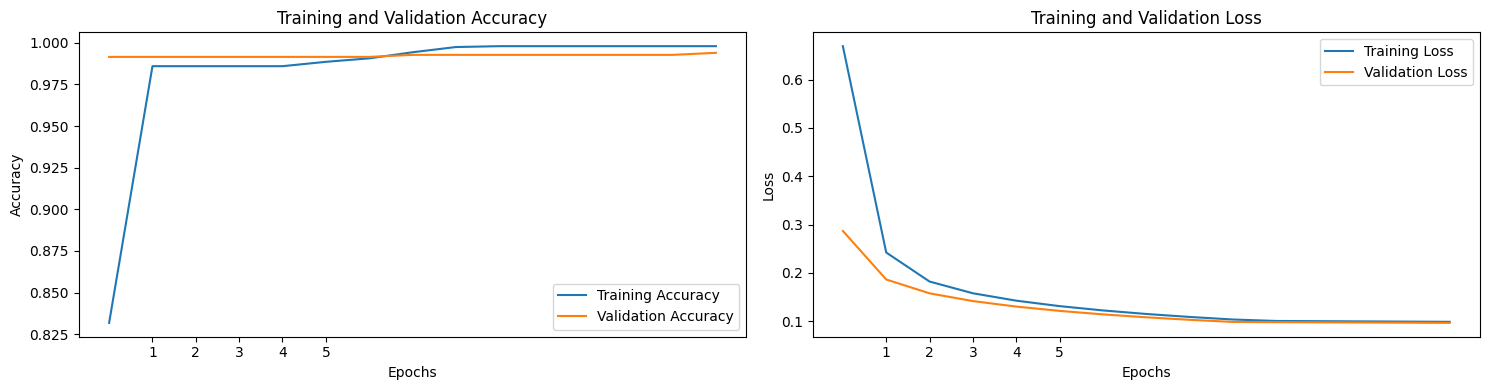

In [77]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xticks(ticks = [1, 2, 3, 4, 5])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xticks(ticks = [1, 2, 3, 4, 5])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

### **Evaluation & Generalization** ###

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


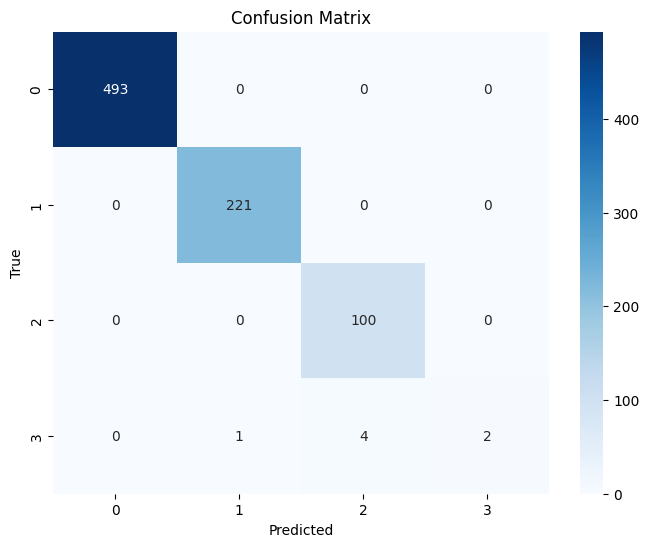

In [78]:
# Calculate confusion matrix of model_tf
#1. get prediction on validation set 
y_pred_prob = model_tf.predict(X_val_enc)
y_pred = np.argmax(y_pred_prob, axis = 1).tolist()

#2. get true class labels of validation set
y_true = y_val.tolist()

#3. calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

#4. plot the confusion matrix
plt.figure(figsize = (8,6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = [0,1,2,3],yticklabels = [0,1,2,3])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [79]:
accurcy_score = accuracy_score(y_true, y_pred)
accurcy_score

0.9939098660170523

In [80]:
f1 = f1_score(y_true, y_pred, average = None)
f1

array([1.        , 0.99774266, 0.98039216, 0.44444444])

In [81]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=2)
metrics.auc(fpr, tpr)

0.9944521497919556

### **Get test result** ###

In [ ]:
parquet_file = {}
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.parquet'):
            key = filename.split('/')[-2]
            parquet_file[key] = pd.read_parquet(os.path.join(dirname, filename))
            globals()[key] = parquet_file[key] 
            break

In [ ]:
list_id = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.parquet'):
            string = os.path.join(dirname, filename)
            id = string.split('/')[-2].split('=')[-1]
            list_id.append(id)
            
num_id = len(set(list_id))
print(num_id)

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.parquet'):
            string = os.path.join(dirname, filename)
            id = string.split('/')[-2].split('=')[-1]
            df_0 = pd.read_parquet(os.path.join(dirname, filename))
            break

In [ ]:
print(id)
print(df_0)